In [1]:
%matplotlib inline

import os
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy.ndimage.filters import gaussian_filter

from spindle_detection import spindles_detect_aln, spindles_detect_thalamus

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

DATA = "data/fig9-aln+thalamus_spindles"
DURATION = 60.0

In [2]:
@dataclass
class Point:
    name: str
    ou_exc: float
    aln_thal: float
    thal_aln: float
    marker: str = "o"
    marker_col: str = "C0"
    size_mult: float = 1.0


def plot_imshow(
    array,
    contour_with=None,
    title="",
    xdim="thalamus-AdEx",
    ydim="AdEx-thalamus",
    cbar_label="",
    vmax=None,
    vmin=None,
    log_colors=False,
    symmetric_around=None,
    cmap="plasma",
    custom_log_ticks=None,
    subplot_str=None,
    plot_points=None,
):
    fig, axes = plt.subplots(
        len(array[ydim]),
        len(array[xdim]),
        sharex=True,
        sharey=True,
        figsize=(11, 11),
    )
    vmin = vmin or array.min().values
    vmax = vmax or array.max().values
    if symmetric_around is not None:
        assert isinstance(symmetric_around, (float, int))
        if log_colors:
            assert symmetric_around == 1.0
            maxi_ = np.amax([np.abs(np.log10(vmin)), np.log10(vmax)])
            vmin = np.power(10, -maxi_)
            vmax = np.power(10, maxi_)
        else:
            maxi_ = np.amax([(symmetric_around - vmin), (vmax - symmetric_around)])
            vmin = symmetric_around - maxi_
            vmax = symmetric_around + maxi_

    plot_points = plot_points or []

    plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.09, top=0.93)
    # reverse this to make 0,0 at lower left
    for ii, adth in enumerate(array[ydim][::-1]):
        for jj, thad in enumerate(array[xdim]):
            ax = axes[ii, jj]
            field = array.sel({ydim: adth.values, xdim: thad.values}).transpose().values
            if contour_with is not None:
                contour = contour_with.sel({ydim: adth.values, xdim: thad.values})
                blurred = gaussian_filter(contour.values, 0.0)
                blurred[blurred < FR_THRESH] = 0
                blurred[blurred >= FR_THRESH] = 1
            ax.imshow(
                field,
                origin="lower",
                cmap=cmap,
                vmin=vmin if not log_colors else None,
                vmax=vmax if not log_colors else None,
                norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax) if log_colors else None,
                extent=[
                    array["ou_exc_mu"].min(),
                    array["ou_exc_mu"].max(),
                    array["ou_inh_mu"].min(),
                    array["ou_inh_mu"].max(),
                ],
            )
            for point in plot_points:
                if point.aln_thal == adth.values and point.thal_aln == thad.values:
                    ax.plot(
                        point.ou_exc / 5.0,
                        3.5 / 5.0,
                        marker=point.marker,
                        color=point.marker_col,
                        markersize=5 * point.size_mult,
                    )
            if contour_with is not None:
                xi, yi = np.meshgrid(array["ou_exc_mu"], array["ou_inh_mu"])
                ax.contour(
                    xi,
                    yi,
                    contour.T,
                    colors="white",
                    linestyles="solid",
                    levels=[0, 1.0001],
                    linewidths=(2,),
                    zorder=1,
                )
            ax.set_title("")
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            if adth == array[ydim].min():
                ax.set_xlabel(f"{thad.values}")
            if thad == array[xdim].min():
                ax.set_ylabel(f"{adth.values}")

    ydim_txt = r"ALN $\to$ thalamus"
    fig.text(0.04, 0.55, ydim_txt, va="center", rotation="vertical", size=22)
    xdim_txt = r"thalamus $\to$ ALN"
    fig.text(0.5, 0.05, xdim_txt, va="center", ha="center", size=22)
    # bottom arrow
    conn = mpl.patches.ConnectionPatch(
        (0.2, 0.065),
        (0.8, 0.065),
        coordsA="figure fraction",
        coordsB="figure fraction",
        arrowstyle="-|>",
        color="k",
        linewidth=2.5,
        mutation_scale=30.0,
    )
    fig.add_artist(conn)
    # left arrow
    conn = mpl.patches.ConnectionPatch(
        (0.08, 0.2),
        (0.08, 0.8),
        coordsA="figure fraction",
        coordsB="figure fraction",
        arrowstyle="-|>",
        color="k",
        linewidth=2.5,
        mutation_scale=30.0,
    )
    fig.add_artist(conn)
    plt.suptitle(title)
    cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.02])
    if log_colors:
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        formatter = mpl.ticker.LogFormatter(10, labelOnlyBase=False)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        formatter = None
    cbar = mpl.colorbar.ColorbarBase(
        cbar_ax,
        cmap=plt.get_cmap(cmap),
        norm=norm,
        format=formatter,
        orientation="horizontal",
    )
    if log_colors and custom_log_ticks:
        assert isinstance(custom_log_ticks, (list, tuple))
        cbar.ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(custom_log_ticks))
        cbar.ax.xaxis.set_ticklabels(custom_log_ticks, minor=False)
    cbar.set_label(cbar_label)
    if subplot_str is not None:
        plt.text(
            0.5,
            1.0,
            subplot_str,
            ha="center",
            va="center",
            transform=fig.transFigure,
            fontsize=50,
        )

In [3]:
subsample_conns = {
    "AdEx-thalamus": slice(None, None, 2),
    "thalamus-AdEx": slice(None, None, 2),
}

spindles = xr.open_dataarray(os.path.join(DATA, "spindles_detection_val_bidir0.3.nc"))
spindles = spindles / DURATION
spindles = spindles.sel(subsample_conns)

ts = xr.open_dataarray(os.path.join(DATA, "ts_selection.nc"))

In [4]:
ts

<xarray.DataArray 'q_mean_EXC' (node: 2, time: 3000, AdEx-thalamus: 2, thalamus-AdEx: 2, ou_exc_mu: 5, noise: 2)>
[240000 values with dtype=float64]
Coordinates:
  * node           (node) float64 0.0 1.0
  * time           (time) float64 5.01 5.02 5.03 5.04 ... 34.97 34.98 34.99 35.0
  * AdEx-thalamus  (AdEx-thalamus) float64 0.4 1.2
  * thalamus-AdEx  (thalamus-AdEx) float64 0.04 0.12
  * ou_exc_mu      (ou_exc_mu) float64 4.0 3.0 2.5 2.75 2.25
    ou_inh_mu      float64 ...
  * noise          (noise) float64 0.0 1.0

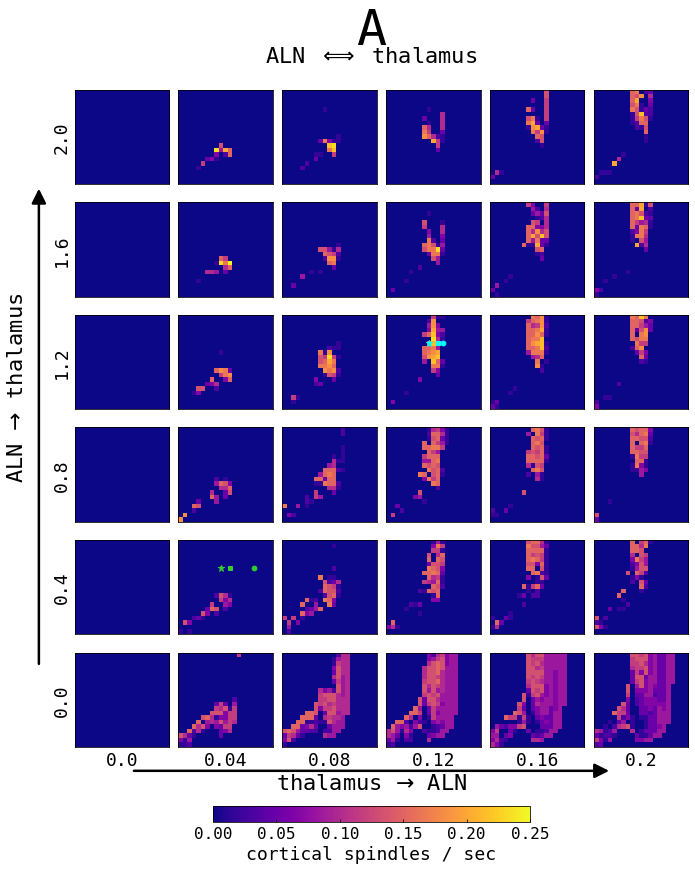

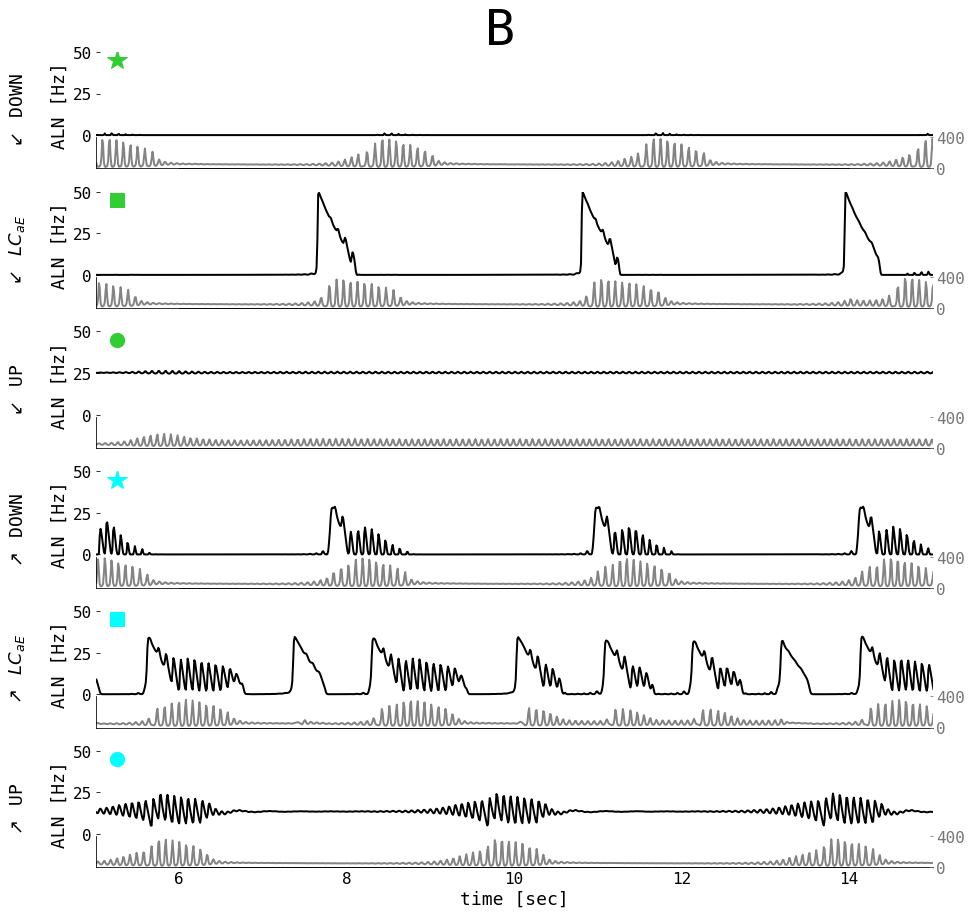

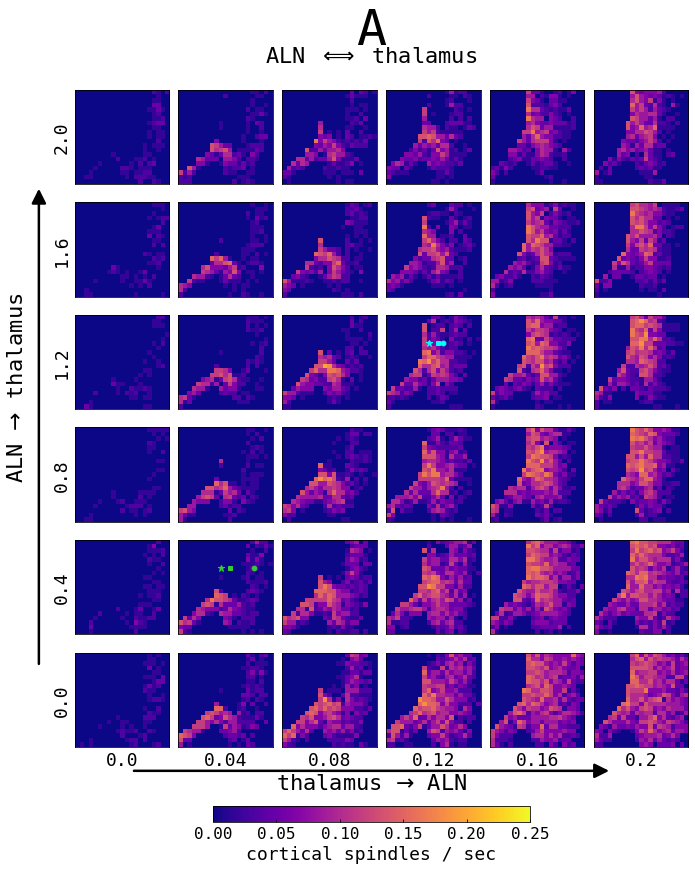

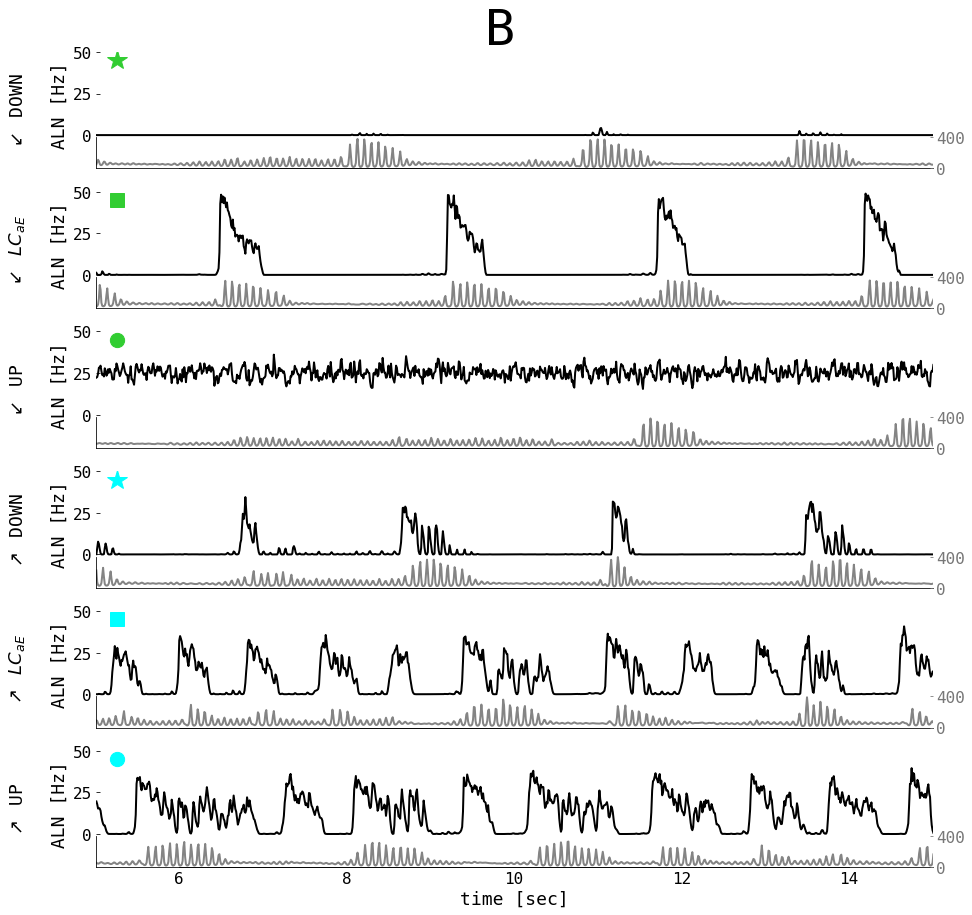

In [6]:
points = [
    Point("$\swarrow$ DOWN", 2.25, 0.4, 0.04, "*", "limegreen", 1.4),
    Point("$\swarrow$ $LC_{aE}$", 2.75, 0.4, 0.04, "s", "limegreen", 0.9),
    Point("$\swarrow$ UP", 4.0, 0.4, 0.04, "o", "limegreen", 0.95),
    Point(r"$\nearrow$ DOWN", 2.25, 1.2, 0.12, "*", "aqua", 1.4),
    Point(r"$\nearrow$ $LC_{aE}$", 2.75, 1.2, 0.12, "s", "aqua", 0.9),
    Point(r"$\nearrow$ UP", 3.0, 1.2, 0.12, "o", "aqua", 0.95),
]


for noise in [0.0, 1.0]:

    if noise == 0:
        aln_n = 0.0
        tcr_n = 0.0
    elif noise == 1:
        aln_n = 0.05
        tcr_n = 0.005

    plot_imshow(
        spindles.sel({"noise": noise, "node": 0.0}),
        vmin=0.0,
        vmax=spindles.sel({"node": 0.0}).max(),
        cbar_label="cortical spindles / sec",
        title="ALN $\\Longleftrightarrow$ thalamus",
        subplot_str="A",
        plot_points=points,
    )
    plt.savefig(
        f"../figs/aln_spindles_aln_sig{aln_n}_tcr_sig{tcr_n}A.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )

    fig, axs = plt.subplots(ncols=1, nrows=len(points), figsize=(15, 15), sharex=True)

    for i, p in enumerate(points):
        sels = {
            "AdEx-thalamus": p.aln_thal,
            "thalamus-AdEx": p.thal_aln,
            "ou_exc_mu": p.ou_exc,
            "noise": noise,
        }
        ts_sels = ts.sel(sels)
        ax = axs[i]
        ax.plot(ts_sels.time, ts_sels.sel({"node": 0.0}) * 1000.0, color="k")
        ax.plot(
            ts_sels.time.values[0] * 1.05,
            45,
            marker=p.marker,
            color=p.marker_col,
            markersize=15 * p.size_mult,
        )
        ax.set_ylim([-20, 50])
        ax.set_xlim([5, 15])
        sns.despine(left=True, ax=ax)
        ax.set_ylabel(f"{p.name} \n \n ALN [Hz]")
        ax2 = ax.twinx()
        ax2.plot(
            ts_sels.time, ts_sels.sel({"node": 1.0}) * 1000.0, color="C3", alpha=0.9
        )
        ax2.set_ylim([0, 1500.0])
        ax2.set_yticks([0, 400])
        ax2.spines["right"].set_color("C3")
        ax2.yaxis.label.set_color("C3")
        ax2.tick_params(axis="y", colors="C3")
        sns.despine(ax=ax2, trim=True)
    axs[-1].set_xlabel("time [sec]")
    plt.text(
        0.5,
        0.9,
        "B",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=50,
    )
    plt.savefig(
        f"../figs/aln_spindles_aln_sig{aln_n}_tcr_sig{tcr_n}B.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )